In [7]:
import pandas as pd
import numpy as np
import matplotlib as plt
import string
import nltk
import csv

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#nltk.download('stopwords')

In [2]:
############# Convert txt file to csv ##############

#Positive tweets
headers = ['Tweet','Sentiment']
df = pd.read_fwf('Datasets/train_pos.txt')
df['new_column'] = '1'
df.to_csv('Datasets/TrainPos.csv', header = headers, index = False)

#Negative tweets
df = pd.read_fwf('Datasets/train_neg.txt')
df['new_column'] = '-1'
df.to_csv('Datasets/TrainNeg.csv', header = None, index = False)


############### Combining Both Files Together ###############

PosReader = csv.reader(open("Datasets/TrainPos.csv"))
NegReader = csv.reader(open("Datasets/TrainNeg.csv"))
f = open("Datasets/FullTrain.csv", "w")
writer = csv.writer(f)

for row in PosReader:
    writer.writerow(row)
for row in NegReader:
    writer.writerow(row)
f.close()

In [8]:
#Create dataframe and store the data from FullTrain.csv

data = pd.DataFrame()
data = pd.read_csv('Datasets/FullTrain.csv', encoding = 'utf-8')
data.head()

,Tweet,Sentiment
0,"because your logic is so dumb , i won't even c...",1
1,""" <user> just put casper in a box ! "" looved t...",1
2,<user> <user> thanks sir > > don't trip lil ma...,1
3,visiting my brother tmr is the bestest birthda...,1
4,<user> yay ! ! #lifecompleted . tweet / facebo...,1


In [4]:
data.shape

(199998, 2)

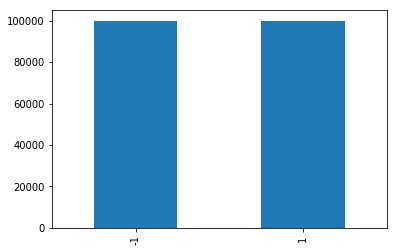

In [4]:
# to see the distribution of the sentiments of the data

%matplotlib inline

data['Sentiment'].value_counts().plot(kind='bar')

In [9]:
#create empty list
tweet_data_list = []

indv_lines = data['Tweet'].values.tolist()
for line in indv_lines:
    
    #create word tokens as well as remove punctuation in one go
    rem_tok_punc = RegexpTokenizer(r'\w+')
    
    tokens = rem_tok_punc.tokenize(line)
    
    #convert the words to lower case
    words = [w.lower() for w in tokens]
    
    #invoke all the English stopwords
    stop_word_list = set(stopwords.words('english'))
    
    #remove stop words
    words = [w for w in words if not w in stop_word_list]
    
    #remove <user> and <url>
    useless = ['user', 'url']
    words = [w for w in words if not w in useless]
    
    #append words in the tweet_data_list list
    tweet_data_list.append(words)

In [20]:
print(len(tweet_data_list))

199998


In [10]:
from gensim.models import Word2Vec

EmbeddingDim = 100

#train Word2Vec model
model = Word2Vec(sentences = tweet_data_list, size = EmbeddingDim, workers = 4, min_count = 1)

In [11]:
#Finding similar words
model.wv.most_similar('friday')

[('thursday', 0.9736646413803101),
 ('saturday', 0.957131028175354),
 ('sunday', 0.9545120596885681),
 ('wednesday', 0.9517480134963989),
 ('monday', 0.9513176679611206),
 ('tuesday', 0.9479730129241943),
 ('nodejsatmicrosoftsvc', 0.9247142672538757),
 ('yay', 0.918641209602356),
 ('weekend', 0.9159681797027588),
 ('dreading', 0.911535918712616)]

In [12]:
#Performing some mathematics on word vectors queen + man - woman = ?
model.wv.most_similar_cosmul(positive=['queen','man'], negative=['woman'])

[('smirnoff', 0.9496944546699524),
 ('ricta', 0.9405534863471985),
 ('heck', 0.9374890923500061),
 ('luongo', 0.9374774098396301),
 ('rght', 0.9323857426643372),
 ('whatchu', 0.931296706199646),
 ('outfit', 0.9290794730186462),
 ('jordans', 0.9276304841041565),
 ('humdado', 0.9273326396942139),
 ('werk', 0.9268401265144348)]

In [24]:
#Finding the odd word out from the list of words given
print(model.wv.doesnt_match("man woman car".split()))

car


/Users/victoriaadcock/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [13]:
# Importing bokeh libraries for showing how words of similar context are grouped together
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

In [14]:
VocabKeys = []
for key in model.wv.vocab.keys():
    VocabKeys.append(key)


#Defining the chart
output_notebook()
plot_chart = bp.figure(plot_width=700, plot_height=600, title="A Plot of 5000 Word Vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

#Extracting the list of word vectors, limiting to 5000, each is of 200 dimensions
word_vectors = [model[w] for w in VocabKeys[:1000]]

Loading BokehJS ...

/Users/victoriaadcock/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


# Reducing dimensionality by converting the vectors to 2d vectors

In [19]:
######### TSNE ##########

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# Storing data in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = VocabKeys[:1000]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.137296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.863392
[t-SNE] KL divergence after 1000 iterations: 0.996733


In [20]:
# Corresponding word appears when you hover on the data point.
plot_chart.scatter(x='x', y='y', source=tsne_df)
hover = plot_chart.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_chart)

In [21]:
######### PCA ##########

from sklearn.decomposition import PCA

pca_model = PCA(n_components=2, random_state=0)
pca_w2v = pca_model.fit_transform(word_vectors)

# Storing data in a dataframe
pca_df = pd.DataFrame(pca_w2v, columns=['x', 'y'])
pca_df['words'] = VocabKeys[:1000]


In [22]:
# Corresponding word appears when you hover on the data point.
plot_chart.scatter(x='x', y='y', source=pca_df)
hover = plot_chart.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_chart)

In [23]:
#Save word embedding model
model_file = 'Datasets/word2vec_embedding.csv'
model.wv.save_word2vec_format(model_file, binary=False)

# Classifying Practise

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [33]:
lr = LogisticRegression(penalty='l2', C=.8, random_state=21)

text_classifier = Pipeline([
    ('vectorizer', CountVectorizer(binary=False, stop_words='english', ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', lr),
#     ('clf', SGDClassifier()), #by default, this is SVM
])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data.Tweet, data.Sentiment, test_size=0.35, random_state=4)

text_classifier.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
  ..., penalty='l2', random_state=21, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [35]:
predicted_test = text_classifier.predict(X_test)
predicted_proba_test = text_classifier.predict_proba(X_test)

In [36]:
from sklearn import metrics

predicted_train = text_classifier.predict(X_train)

y_train = y_train.astype('category')
print(metrics.classification_report(y_train, predicted_train,
    labels=y_train.cat.categories.tolist()))

metrics.confusion_matrix(y_train, predicted_train)

              precision    recall  f1-score   support

          -1       0.89      0.86      0.88     65073
           1       0.87      0.90      0.88     64925

   micro avg       0.88      0.88      0.88    129998
   macro avg       0.88      0.88      0.88    129998
weighted avg       0.88      0.88      0.88    129998



array([[56016,  9057],
       [ 6729, 58196]])

In [37]:
predicted_test = text_classifier.predict(X_test)

y_test = y_test.astype('category')
print(metrics.classification_report(y_test, predicted_test,
    labels=y_test.cat.categories.tolist()))

metrics.confusion_matrix(y_test, predicted_test)

              precision    recall  f1-score   support

          -1       0.81      0.77      0.79     34926
           1       0.78      0.82      0.80     35074

   micro avg       0.80      0.80      0.80     70000
   macro avg       0.80      0.80      0.80     70000
weighted avg       0.80      0.80      0.80     70000



array([[26990,  7936],
       [ 6282, 28792]])